In [ ]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [ ]:
path = '1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)


In [ ]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [ ]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])


['project', 'gutenberg', 's', 'the', 'adventures']
of


In [ ]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))


In [ ]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
811/811 [==============================] - 227s 277ms/step - loss: 6.0155 - accuracy: 0.1071 - val_loss: 7.1106 - val_accuracy: 0.1018
Epoch 2/20
811/811 [==============================] - 258s 318ms/step - loss: 5.7856 - accuracy: 0.1476 - val_loss: 7.8058 - val_accuracy: 0.1067
Epoch 3/20
811/811 [==============================] - 258s 318ms/step - loss: 5.7531 - accuracy: 0.1758 - val_loss: 8.0398 - val_accuracy: 0.1016
Epoch 4/20
811/811 [==============================] - 258s 319ms/step - loss: 5.4705 - accuracy: 0.2091 - val_loss: 8.3307 - val_accuracy: 0.1047
Epoch 5/20
811/811 [==============================] - 256s 316ms/step - loss: 5.1657 - accuracy: 0.2484 - val_loss: 8.2050 - val_accuracy: 0.1005
Epoch 6/20
811/811 [==============================] - 256s 315ms/step - loss: 4.9029 - accuracy: 0.2874 - val_loss: 8.6431 - val_accuracy: 0.0912
Epoch 7/20
811/811 [==============================] - 256s 316ms/step - loss: 4.7002 - accuracy: 0.3248 - val_loss: 8.7506 -

In [ ]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

In [ ]:
history

{'accuracy': [0.10708468407392502,
  0.147640198469162,
  0.1757630705833435,
  0.2091095745563507,
  0.24840255081653595,
  0.2873871326446533,
  0.32482001185417175,
  0.3620312511920929,
  0.3968523144721985,
  0.42792433500289917,
  0.45408108830451965,
  0.4768839478492737,
  0.49705567955970764,
  0.5162540078163147,
  0.5351921319961548,
  0.5520002841949463,
  0.56261146068573,
  0.5726828575134277,
  0.5822820067405701,
  0.5902138352394104],
 'loss': [6.015527725219727,
  5.785642623901367,
  5.753149509429932,
  5.47052526473999,
  5.16569709777832,
  4.902949810028076,
  4.700191497802734,
  4.503874778747559,
  4.343661308288574,
  4.20799446105957,
  4.086950778961182,
  4.007993221282959,
  3.9392402172088623,
  3.8584141731262207,
  3.7712318897247314,
  3.6924688816070557,
  3.6534667015075684,
  3.6133320331573486,
  3.5544545650482178,
  3.5091586112976074],
 'val_accuracy': [0.10179421305656433,
  0.10673745721578598,
  0.10161112993955612,
  0.10472354292869568,
  

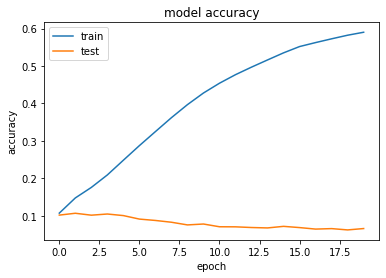

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

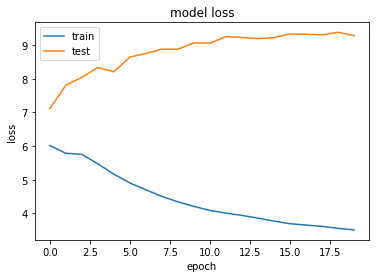

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [ ]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    
]

In [ ]:
import re

for q in quotes:
    q = re.sub('[^A-Za-z0-9]+', ' ', q)
    seq = q[:39].lower()
    print(seq)
    
    print(predict_completions(seq,5))
    


it is not a lack of love but a lack of 
['the ', 'an ', 'such ', 'man ', 'present, ']
that which does not kill us makes us st
['ength ', 'uggle ', 'ong ', 'ange ', 'ive ']
i m not upset that you lied to me i m u
['nder ', 'pon ', 'ses ', 't ', 'uder ']
